In [71]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import save_img
import os
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import cv2
from pathlib import Path
import shutil
from sklearn.metrics import confusion_matrix

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


## Parâmetros globais

In [12]:
#bsize
bSize=10
#tamanho para qual todas as imagens irão ser resized
ISize=(256,256)

## Funções Auxiliares

Função para obter loss e a accuracy ao longo do treino no conjunto de treino e validação

In [13]:
def get_train_history(train):
    h=train.history
    h.keys()
    plt.figure(figsize=(10,5))
    plt.plot(h['loss'], label='Loss_train')
    plt.plot(h['val_loss'], label='Loss_val')
    plt.plot(h['accuracy'], label='Accuracy_train')
    plt.plot(h['val_accuracy'], label='Accuracy_val')
    plt.legend()
    plt.grid()
    plt.show()
    

Função para dar plot na matriz de confusão

In [14]:
# -*- coding: utf-8 -*-
import numpy as np
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig=plt.figure(figsize=(6.5,6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

<hr style="border:2px solid black"> </hr>

### Ler dados do ficheiro pickle

Inicialmente é necessário ler os dados do ficheiro pickle do Oxford-IIIT-Pet_Dics

In [16]:
#p_path ="C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\Oxford-IIIT-Pet_Dics.p"
p_path="Oxford-IIIT-Pet_Dics.p"
D=pickle.load(open(p_path,'rb'))


In [17]:
classes = D['classDic']

Realizar resize das imagens com padding

In [18]:
files = D['filesDic']

In [19]:
key_list = list(files.keys())
val_list = list(files.values())

<hr style="border:2px solid black"> </hr>

## Ler as imagens do ficheiro

Path onde as imagens estão guardadas

In [21]:
PATH_IMGS = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images\\images"

In [39]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(PATH_IMGS, '*.jpg'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 7390


In [42]:
images=[]
for imgName in imageNames:
    img = plt.imread(os.path.join(PATH_IMGS, imgName))
    images.append(img)
    

In [ ]:
print(len(images))

## Verificar se há Imagens com dimensões diferentes de 3

Um cuidado que foi necessário ter foi assegurar que todas as imagens têm o mesmo dimensões do channel. Foi então criada a seguinte função para verificar o número de imagens com channel com dimensões diferentes de 3.

In [43]:
def checkImagesDimensions(images):

    dim2=0
    dim4=0

    for img in  (images):

        if len(img.shape) ==2:
            dim2=dim2+1
            plt.figure()
            plt.imshow(img)
    
        if len(img.shape)>2:
            if img.shape[2] ==4:
                dim4=dim4+1
                plt.figure()
                plt.imshow(img)
    
    print("Number of images with only 2 dimensions: ",dim2)
    print("Number of images with 4 dimensions: ",dim4)
    


Number of images with only 2 dimensions:  3
Number of images with 4 dimensions:  9


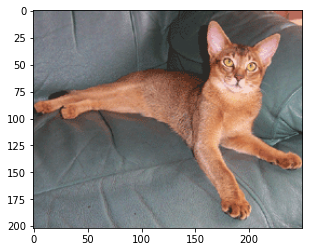

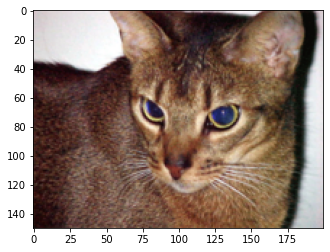

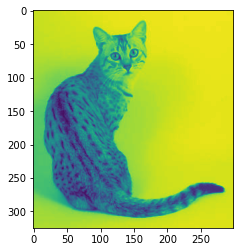

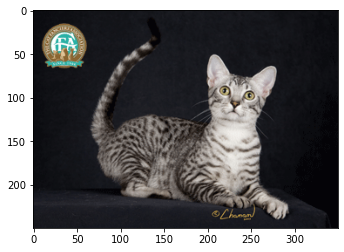

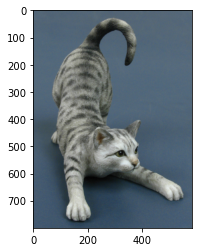

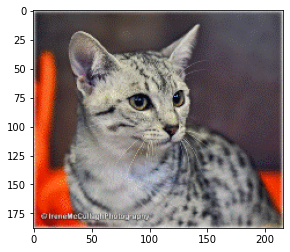

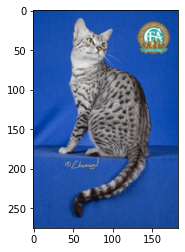

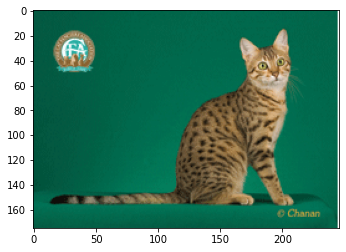

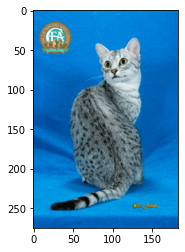

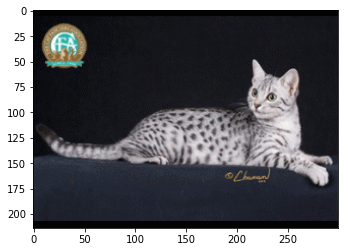

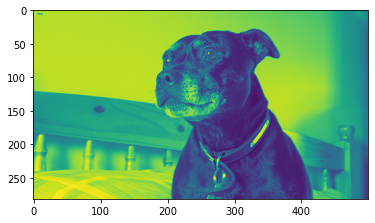

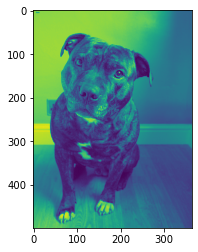

In [44]:
checkImagesDimensions(images)

Verificou-se que existem:
* 3 imagens com apenas 2 dimensões
* 4 imagens com 4 dimensões

## CARREGAR IMAGENS DO DISCO

In [45]:
imageData = []

for name in (imageNames):
    img = load_img(os.path.join(PATH_IMGS, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *ISize).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

(7390, 256, 256, 3)

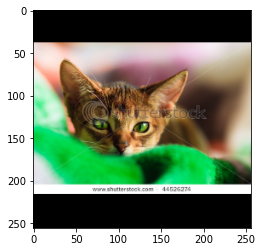

In [46]:
img = imageData[3]
plt.imshow(img)

## Save Image to files

In [47]:
type(img)

numpy.ndarray

imageData -> np array com as imagens

In [48]:
imageData[3].shape

(256, 256, 3)

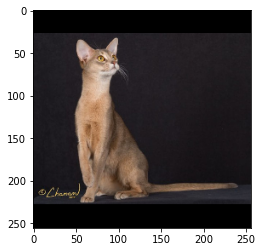

In [49]:
plt.imshow(imageData[100],cmap='binary')

<hr style="border:2px solid black"> </hr>

### Obter x e y para imagens carregadas do disco

In [50]:
#fazer um array de indexes em que foldTrain = true


def get_indexes_arr_train_test(val_list):

    idxTrain=[]
    idxTest=[]

    for  i in range (len(val_list)):
    
        if (val_list[i]["foldTrain"]):
        
            idxTrain.append(i)
        else:
            idxTest.append(i)
    
    return idxTrain,idxTest


def get_y(val_list):
    
    y = []
    
    for i in range(len(val_list)):
    
        y.append(val_list[i]["target"])
    
    y= np.array(y)
    return y

def get_y_bin(val_list):
    
    ybin = []
    
    for i in range (len(val_list)):
        
        if (val_list[i]["species"] == "cat"):
            ybin.append(0)
        else:
            ybin.append(1)
    
    ybin = np.array(ybin)
    return ybin
        
            

In [51]:
y = get_y(val_list)
ybin = get_y_bin(val_list)
idxTrain, idxTest = get_indexes_arr_train_test(val_list)

In [52]:
x_test = imageData[idxTest]
x_train = imageData[idxTrain]

In [53]:
y_train = y[idxTrain]
y_test = y[idxTest]
labels = np.unique(y)

In [54]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = x_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

NameError: name 'BATCH_SIZE' is not defined

<hr style="border:2px solid black"> </hr>

## Criar diferentes diretorias para dados de treino e teste para MULTICLASSE

estas duas funcoes sao antigas mas podem dar jeito!

In [131]:
'''
def saveImageFolderBin(imgName,isTrain, class_name):
    
    
    source_path = 'C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images\\images'+"\\"+imgName
   
    target_path_train = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin\\train"
    target_path_test = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin\\test"
    
    if (isTrain):
        
        class_path = os.path.join(target_path_train,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        
    else:
        
        class_path = os.path.join(target_path_test,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
    
    try:
        shutil.copyfile(source_path, target_path)
 
    except:
        print("Error occurred while copying file.")

'''

In [183]:
'''
def saveToFolderMulti(imgName,isTrain, class_name,image):
    
    
    source_path = 'C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images\\images'+"\\"+imgName
   
    target_path_train = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation\\train"
    target_path_test = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation\\test"
    
    if (isTrain):
        class_path = os.path.join(target_path_train,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
        
    else:
        class_path = os.path.join(target_path_test,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
'''

In [190]:
def saveToFolder(imgName,isTrain, class_name,image,isMulti):
    
    if (isMulti==False):

        target_path_train = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin\\train"
        target_path_test = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin\\test"
    else:
        
        target_path_train = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation\\train"
        target_path_test = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation\\test"
        
    if (isTrain):
        class_path = os.path.join(target_path_train,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
        
    else:
        class_path = os.path.join(target_path_test,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
    

Esta função passa as imagens da diretoria base para diretorias separadas. As imagens são processadas e saved nos ficheiros especificos. As imagens no images ja estão pre-processadas.

In [196]:
def create_train_test_directorys(isMulti, images):

    if (isMulti):
    #base directory path
        base_path = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation"
    else:
        base_path = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin"
    #create test and train directories
    
    train_path = os.path.join(base_path,'train')
    test_path = os.path.join(base_path,'test')
    print(train_path)
    if (os.path.isdir(train_path)==False ):
        os.mkdir(train_path)
    
    if(os.path.isdir(test_path)==False):
        os.mkdir(test_path)

    for i in range (len(key_list)):
        if (isMulti):
            if (val_list[i]["foldTrain"]):
                #ler imagem e dar save no sitio certo
                saveToFolder(key_list[i],True,val_list[i]["breed"],images[i],True)
                
                #saveImageFolderMulti(key_list[i],True,val_list[i]["breed"])
            else:
                saveToFolder(key_list[i],False,val_list[i]["breed"],images[i],True)
                #saveImageFolderMulti(key_list[i],False,val_list[i]["breed"])
        
        else:
            if (val_list[i]["foldTrain"]):
                saveToFolder(key_list[i],True,val_list[i]["species"],images[i],False)
                #saveImageFolderBin(key_list[i],True,val_list[i]["species"])
            else:
                saveToFolder(key_list[i],False,val_list[i]["species"],images[i],False)
                #saveImageFolderBin(key_list[i],False,val_list[i]["species"])
                
    


In [198]:
create_train_test_directorys(False, imageData)

C:\Users\duart\OneDrive\Ambiente de Trabalho\Mestrado\AAA\TP3\images_generation_bin\images_generation_bin\train


In [180]:
path="C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation_bin\\images_generation_bin\\train\\Abyssinian\\Abyssinian_1.jpg"

save_img(path, imageData[0])

<hr style="border:2px solid black"> </hr>

## Data generator for data augmentation

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dbDir = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images_generation\\images_generation"

In [56]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


train_data = train_gen.flow_from_directory(directory=dbDir+"\\train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 37 classes.


### Image Data Generator for testing data

In [57]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_data = test_gen.flow_from_directory(directory=dbDir+"\\test",
target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

Found 3704 images belonging to 37 classes.


## Mostrar as imagens

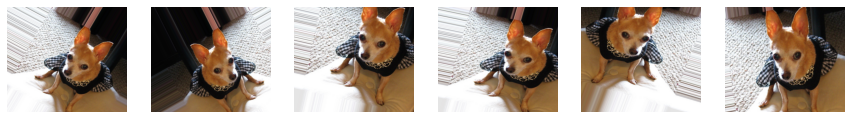

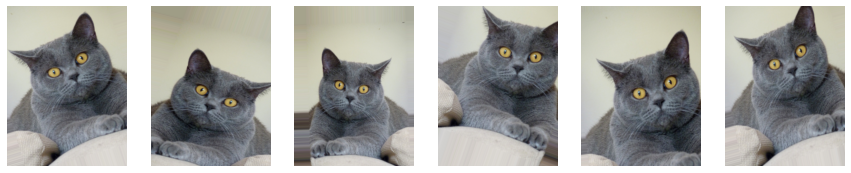

In [58]:
from keras.preprocessing import image


#MOSTRAR CAO
fN = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images\\images\\chihuahua_53.jpg"

I=image.load_img(fN,ISize)
I=image.img_to_array(I)

I=I[np.newaxis,:,:,:]

n=0
#alterei
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,15))

for A in train_gen.flow(I,batch_size=1):
    A=A.squeeze() 
    A=A-A.min()
    A=A/A.max()*255
    
    #alterei
    ax[n].imshow(np.uint8(A))
    ax[n].axis('off')
    
    #alterei 
    n+=1
    if n>5:
        break

#MOSTRAR GATO

fN = "C:\\Users\\duart\\OneDrive\\Ambiente de Trabalho\\Mestrado\\AAA\\TP3\\images\\images\\British_Shorthair_58.jpg"

I=image.load_img(fN,ISize)
I=image.img_to_array(I)

I=I[np.newaxis,:,:,:]

n=0
#alterei
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,15))

for A in train_gen.flow(I,batch_size=1):
    A=A.squeeze() 
    A=A-A.min()
    A=A/A.max()*255
    
    #alterei
    ax[n].imshow(np.uint8(A))
    ax[n].axis('off')
    
    #alterei 
    n+=1
    if n>5:
        break




<hr style="border:2px solid black"> </hr>

## Treinar utilizando modelos pre-treinados do kanvas

Há vários modelos pre-treinados disponivéis no Keras. Estes modelos são fácilmente carregados. De seguida vão ser testados e utilizados diferentes modelos.

Os modelos pre-treinados vão ser importados do Keras Applications com pesos pre-treinados. Estes modelos podem ser utilizados para prediction, feature extraction.

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception

ISize=(256,256)

dataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input, 
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


trainGen = dataGen1.flow_from_directory(directory=dbDir+"\\train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 37 classes.


In [103]:
dataGen2=ImageDataGenerator(preprocessing_function=preprocess_input)


testGen=dataGen2.flow_from_directory(directory=dbDir+"\\test",
target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

Found 3704 images belonging to 37 classes.


In [104]:
from keras.applications.xception import Xception

cnnBase = Xception(weights="imagenet",include_top=False, input_shape=(256,256,3))
cnnBase.trainable=False

cnn2=keras.models.Sequential()
cnn2.add(cnnBase)
cnn2.add(keras.layers.MaxPooling2D((2, 2)))
cnn2.add(keras.layers.Flatten())
cnn2.add(keras.layers.Dropout(.3))
cnn2.add(keras.layers.Dense(32,activation="relu"))
cnn2.add(keras.layers.Dense(37, activation="softmax"))

cnn2.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])



## Train Network

In [95]:
# fazer aqui train history

In [106]:
ePochs=20
speTrain=3686 //bSize
speValid=3704 //bSize
train=cnn2.fit(trainGen,steps_per_epoch=speTrain,validation_data=testGen,validation_steps=speValid,epochs=ePochs)

Epoch 1/20
368/368 [==============================] - 61s 165ms/step - loss: 1.2885 - accuracy: 0.6540 - val_loss: 1.2089 - val_accuracy: 0.6350
Epoch 2/20
368/368 [==============================] - 62s 168ms/step - loss: 0.8624 - accuracy: 0.7568 - val_loss: 0.9185 - val_accuracy: 0.7090
Epoch 3/20
368/368 [==============================] - 60s 164ms/step - loss: 0.6889 - accuracy: 0.8060 - val_loss: 0.8810 - val_accuracy: 0.7420
Epoch 4/20
368/368 [==============================] - 55s 149ms/step - loss: 0.6329 - accuracy: 0.8169 - val_loss: 0.8852 - val_accuracy: 0.7200
Epoch 5/20
368/368 [==============================] - 58s 159ms/step - loss: 0.5375 - accuracy: 0.8490 - val_loss: 0.8316 - val_accuracy: 0.7530
Epoch 6/20
368/368 [==============================] - 61s 165ms/step - loss: 0.5493 - accuracy: 0.8379 - val_loss: 1.0333 - val_accuracy: 0.7170
Epoch 7/20
368/368 [==============================] - 61s 165ms/step - loss: 0.4908 - accuracy: 0.8498 - val_loss: 0.8532 - val_ac

In [109]:
y2e=cnn2.predict(testGen,steps=(3704//bSize) +1,verbose=1)
Y2=np.argmax(y2e,axis=1)

print(y2e.shape)
print(len(Y2))

M2=confusion_matrix(testGen.classes, Y2)
print(M2)
print("%d erros em %d exemplos"%(np.sum(testGen.classes!=Y2),testGen.classes.shape[0]))
print("%Accuracy:",(100-np.sum(testGen.classes!=Y2)*100/testGen.classes.shape[0]))

371/371 [==============================] - 22s 54ms/step
(3704, 37)
3704
[[96  0  0 ...  0  0  0]
 [ 0 59 16 ...  3  0  0]
 [ 0  6 66 ... 19  0  0]
 ...
 [ 0  2 27 ... 53  0  0]
 [ 0  0  0 ...  0 90  1]
 [ 0  0  0 ...  0  1 98]]
587 erros em 3704 exemplos
%Accuracy: 84.15226781857451


In [78]:
len(Y2)

1000

## FAZER REDE CONVULOCIONAL XD

In [182]:
LEARNING_RATE=0.0001

In [183]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 5, padding = 'same', input_shape = (*ISize, 3)))
model.add(keras.layers.Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32, 4, padding = 'same'))
model.add(keras.layers.Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, 4, padding = 'same'))
model.add(keras.layers.Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 3, padding = 'same'))
model.add(keras.layers.Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, 3, padding = 'same'))
model.add(keras.layers.Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(128, 2, padding = 'same'))
model.add(keras.layers.Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(256, 2, padding = 'same'))
model.add(keras.layers.Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)))
model.add(keras.layers.MaxPooling2D())
    
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512, activation = 'sigmoid'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation = 'sigmoid'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(len(labels), activation = 'softmax'))
    

model.compile(optimizer = tf.keras.optimizers.Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 conv2d_59 (Conv2D)          (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 112, 112, 32)      16416     
                                                                 
 conv2d_61 (Conv2D)          (None, 112, 112, 32)      16416     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 